# DL speed changes pre/post contact (interior reps)

This notebook builds the diagnostics needed to support the "DL speed changes pre -> post contact" story using `df_with_features_v2.csv`.


In [30]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")


In [31]:
DATA_PATH = "~/Desktop/ShrineBowlSumerSportsAnalyticsCompetition/Output/df_with_features.csv"

df = pl.read_csv(DATA_PATH)
df.shape


(4641, 55)

In [32]:
FRAME_DT = 0.1
MATCHUP_TYPE_FILTER = "INTERIOR"

if "matchup_type" in df.columns:
    df = df.filter(pl.col("matchup_type") == MATCHUP_TYPE_FILTER)

df = df.filter(pl.col("contact_onset_frame").is_not_null())

rep_id_expr = pl.concat_str(
    [
        pl.col("session_name"),
        pl.col("rep_number").cast(pl.Utf8),
        pl.col("dl_zebra_id").cast(pl.Utf8),
        pl.col("ol_zebra_id").cast(pl.Utf8),
    ],
    separator="|",
)

df = df.with_columns(
    [
        rep_id_expr.alias("rep_id"),
        pl.when(pl.col("frame_delta").is_not_null())
        .then(pl.col("frame_delta").cast(pl.Float64) * FRAME_DT)
        .otherwise(pl.lit(FRAME_DT))
        .alias("frame_dt"),
        (pl.col("frame_number") - pl.col("contact_onset_frame")).alias("rel_frame"),
    ]
)

df = df.sort(["rep_id", "frame_number"]).with_columns(
    (
        (pl.col("pairwise_distance").shift(1).over("rep_id") - pl.col("pairwise_distance"))
        / pl.col("frame_dt")
    ).alias("v_close")
)

df.select([pl.len().alias("rows"), pl.col("rep_id").n_unique().alias("reps")])


rows,reps
u32,u32
2749,65


In [33]:
df_pd = df.to_pandas()
df_pd = df_pd.sort_values(["rep_id", "frame_number"])

# Derive turning-related metrics for COD checks.
df_pd["dl_dir_rad"] = np.deg2rad(df_pd["dl_dir"])

df_pd["ol_dir_rad"] = np.deg2rad(df_pd["ol_dir"])

def add_turning_metrics(g):
    g = g.copy()

    dl_dir_series = pd.Series(g["dl_dir_rad"].to_numpy())
    if dl_dir_series.isna().all():
        g["omega_dl"] = np.nan
        g["a_lat_dl"] = np.nan
        g["jerk_dl"] = np.nan
    else:
        dl_dir_vals = dl_dir_series.interpolate(limit_direction="both").to_numpy()
        dl_dir_unwrapped = np.unwrap(dl_dir_vals)
        dt = g["frame_dt"].to_numpy()
        omega_dl = np.full(len(g), np.nan, dtype=float)
        omega_dl[1:] = np.diff(dl_dir_unwrapped) / dt[1:]
        a_lat_dl = g["dl_s"].to_numpy() * omega_dl
        jerk_dl = np.full(len(g), np.nan, dtype=float)
        jerk_dl[1:] = np.diff(g["dl_a"].to_numpy()) / dt[1:]
        g["omega_dl"] = omega_dl
        g["a_lat_dl"] = a_lat_dl
        g["jerk_dl"] = jerk_dl

    ol_dir_series = pd.Series(g["ol_dir_rad"].to_numpy())
    if ol_dir_series.isna().all():
        g["omega_ol"] = np.nan
        g["a_lat_ol"] = np.nan
        g["jerk_ol"] = np.nan
    else:
        ol_dir_vals = ol_dir_series.interpolate(limit_direction="both").to_numpy()
        ol_dir_unwrapped = np.unwrap(ol_dir_vals)
        dt = g["frame_dt"].to_numpy()
        omega_ol = np.full(len(g), np.nan, dtype=float)
        omega_ol[1:] = np.diff(ol_dir_unwrapped) / dt[1:]
        a_lat_ol = g["ol_s"].to_numpy() * omega_ol
        jerk_ol = np.full(len(g), np.nan, dtype=float)
        jerk_ol[1:] = np.diff(g["ol_a"].to_numpy()) / dt[1:]
        g["omega_ol"] = omega_ol
        g["a_lat_ol"] = a_lat_ol
        g["jerk_ol"] = jerk_ol

    return g

df_pd = df_pd.groupby("rep_id", group_keys=False).apply(add_turning_metrics)

rep_meta_cols = [
    "rep_id",
    "session_name",
    "rep_number",
    "dl_player_name",
    "dl_zebra_id",
    "ol_player_name",
    "ol_zebra_id",
    "contact_onset_frame",
    "window_start",
    "window_end",
]
rep_meta = df_pd.groupby("rep_id", as_index=False).first()[rep_meta_cols]

/var/folders/5y/32z924550g93tmjyy3r_9fdw0000gn/T/ipykernel_36520/2422848802.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pd = df_pd.groupby("rep_id", group_keys=False).apply(add_turning_metrics)


In [34]:
REL_FRAME_MIN = -10
REL_FRAME_MAX = 10
PRE_FRAMES = 6
POST_FRAMES = 6
BOOTSTRAP_SAMPLES = 2000


def bootstrap_ci(data, stat_fn, n_boot=BOOTSTRAP_SAMPLES, ci=0.95, seed=0):
    data = np.asarray(data)
    if data.size == 0:
        return (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    boots = [stat_fn(rng.choice(data, size=data.size, replace=True)) for _ in range(n_boot)]
    low, high = np.quantile(boots, [(1 - ci) / 2, 1 - (1 - ci) / 2])
    return low, high


def compute_pre_post_by_rep(df, value_col, pre_frames=PRE_FRAMES, post_frames=POST_FRAMES, center_offset=0):
    rows = []
    for rep_id, g in df.groupby("rep_id"):
        center = g["contact_onset_frame"].iloc[0] + center_offset
        pre_mask = (g["frame_number"] >= center - pre_frames) & (g["frame_number"] <= center - 1)
        post_mask = (g["frame_number"] >= center) & (g["frame_number"] <= center + post_frames)
        pre_mean = g.loc[pre_mask, value_col].mean()
        post_mean = g.loc[post_mask, value_col].mean()
        if pd.notna(pre_mean) and pd.notna(post_mean):
            rows.append({"rep_id": rep_id, "pre": pre_mean, "post": post_mean, "delta": post_mean - pre_mean})
    return pd.DataFrame(rows)


def plot_contact_aligned_spaghetti(df, value_col, title, rel_min=REL_FRAME_MIN, rel_max=REL_FRAME_MAX, max_reps=80):
    colors = {
        "bar": "#4D7C94",
        "grid": "#546B82",
        "axis_text": "#DDE0E2",
        "highlight_red": "#E55934",
        "highlight_gold": "#D89E35",
    }
    
    subset = df[(df["rel_frame"] >= rel_min) & (df["rel_frame"] <= rel_max)]
    fig, ax = plt.subplots(figsize=(10, 6))
    rep_ids = subset["rep_id"].unique()
    if len(rep_ids) > max_reps:
        rng = np.random.default_rng(0)
        rep_ids = rng.choice(rep_ids, size=max_reps, replace=False)
    plot_df = subset[subset["rep_id"].isin(rep_ids)]
    for rep_id, g in plot_df.groupby("rep_id"):
        ax.plot(g["rel_frame"], g[value_col], color="gray", alpha=0.2, linewidth=0.7)
    summary = subset.groupby("rel_frame")[value_col].agg(
        mean="mean",
        q10=lambda x: x.quantile(0.1),
        q50="median",
        q90=lambda x: x.quantile(0.9),
    ).reset_index()
    ax.plot(summary["rel_frame"], summary["mean"], color="black", linewidth=2, label="mean")
    ax.plot(summary["rel_frame"], summary["q50"], color="tab:blue", linewidth=2, label="median")
    ax.plot(summary["rel_frame"], summary["q10"], color="tab:blue", linestyle="--", linewidth=1, label="10/90%")
    ax.plot(summary["rel_frame"], summary["q90"], color="tab:blue", linestyle="--", linewidth=1)
    ax.axvline(0, color="red", linestyle=":", linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("Frames relative to contact onset frame", fontsize=13, labelpad=10, color=colors["axis_text"])
    ax.set_xticks([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
    ax.set_ylabel(value_col)
    ax.legend()
    return fig, ax


def plot_contact_aligned_spaghetti_hist_style(df, value_col, title, rel_min=REL_FRAME_MIN, rel_max=REL_FRAME_MAX, max_reps=80, output_path=None):
    colors = {
        "bar": "#4D7C94",
        "grid": "#546B82",
        "axis_text": "#DDE0E2",
        "highlight_red": "#E55934",
        "highlight_gold": "#D89E35",
    }

    subset = df[(df["rel_frame"] >= rel_min) & (df["rel_frame"] <= rel_max)]
    fig, ax = plt.subplots(figsize=(10, 6))
    rep_ids = subset["rep_id"].unique()
    if len(rep_ids) > max_reps:
        rng = np.random.default_rng(0)
        rep_ids = rng.choice(rep_ids, size=max_reps, replace=False)
    plot_df = subset[subset["rep_id"].isin(rep_ids)]
    for _, g in plot_df.groupby("rep_id"):
        ax.plot(g["rel_frame"], g[value_col], color=colors["bar"], alpha=0.2, linewidth=0.7)

    summary = subset.groupby("rel_frame")[value_col].agg(
        mean="mean",
        q10=lambda x: x.quantile(0.1),
        q50="median",
        q90=lambda x: x.quantile(0.9),
    ).reset_index()
    ax.plot(summary["rel_frame"], summary["mean"], color=colors["highlight_red"], linewidth=2, label="mean")
    ax.plot(summary["rel_frame"], summary["q50"], color=colors["highlight_gold"], linewidth=2, label="median")
    ax.plot(summary["rel_frame"], summary["q10"], color=colors["highlight_gold"], linestyle="--", linewidth=1, label="10/90%")
    ax.plot(summary["rel_frame"], summary["q90"], color=colors["highlight_gold"], linestyle="--", linewidth=1)
    ax.axvline(0, color=colors["grid"], linestyle="--", linewidth=1.5, alpha=0.6)

    ax.yaxis.grid(True, linestyle="--", which="major", color=colors["grid"], alpha=0.5, zorder=0, linewidth=1)
    ax.set_axisbelow(True)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_color(colors["bar"])
    ax.spines["bottom"].set_linewidth(1)

    ax.set_title(title, fontsize=18, fontweight="bold", pad=14, color=colors["axis_text"])
    ax.set_xlabel("Frames relative to contact onset frame", fontsize=13, labelpad=10, color=colors["axis_text"])
    ax.set_xticks([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
    ax.set_ylabel(value_col, fontsize=13, labelpad=10, color=colors["axis_text"])

    ax.tick_params(axis="x", colors=colors["axis_text"], length=5, labelsize=12)
    ax.tick_params(axis="y", colors=colors["axis_text"], length=0, pad=10, labelsize=12)

    legend = ax.legend(loc="upper left", frameon=True, fancybox=True, framealpha=0.0)
    legend.get_frame().set_facecolor("none")
    legend.get_frame().set_edgecolor("none")
    for text in legend.get_texts():
        text.set_color(colors["axis_text"])
        text.set_fontsize(13)

    ax.set_facecolor("none")
    fig.patch.set_alpha(0)

    if output_path:
        fig.savefig(output_path, format="svg", transparent=True)

    return fig, ax


def plot_pre_post_scatter(pre_post_df, title, x_label="Pre mean", y_label="Post mean"):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(pre_post_df["pre"], pre_post_df["post"], alpha=0.7, edgecolor="none")
    min_val = np.nanmin([pre_post_df["pre"].min(), pre_post_df["post"].min()])
    max_val = np.nanmax([pre_post_df["pre"].max(), pre_post_df["post"].max()])
    ax.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="black", linewidth=1)
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    return fig, ax


def plot_delta_distribution(pre_post_df, title, n_boot=BOOTSTRAP_SAMPLES):
    data = pre_post_df["delta"].dropna().to_numpy()
    fig, ax = plt.subplots(figsize=(7, 4))
    sns.violinplot(x=data, ax=ax, inner=None, color="lightgray")
    sns.boxplot(x=data, ax=ax, width=0.2, boxprops=dict(facecolor="white"))
    mean = np.mean(data)
    median = np.median(data)
    mean_ci = bootstrap_ci(data, np.mean, n_boot=n_boot)
    median_ci = bootstrap_ci(data, np.median, n_boot=n_boot)
    ax.axvline(0, color="red", linestyle=":", linewidth=1)
    ax.axvline(mean, color="black", linewidth=2, label=f"mean {mean:.3f}")
    ax.axvline(median, color="tab:blue", linewidth=2, label=f"median {median:.3f}")
    ax.set_title(title)
    ax.set_xlabel("Delta (post - pre)")
    ax.legend()
    ci_text = f"mean CI {mean_ci[0]:.3f}..{mean_ci[1]:.3f} | median CI {median_ci[0]:.3f}..{median_ci[1]:.3f}"
    ax.text(0.01, 0.95, ci_text, transform=ax.transAxes, ha="left", va="top")
    return fig, ax





In [35]:
dl_speed_pre_post = compute_pre_post_by_rep(df_pd, "dl_s", pre_frames=PRE_FRAMES, post_frames=POST_FRAMES)
dl_speed_pre_post = dl_speed_pre_post.merge(rep_meta, on="rep_id", how="left")

dl_accel_pre_post = compute_pre_post_by_rep(df_pd, "dl_a", pre_frames=PRE_FRAMES, post_frames=POST_FRAMES)
dl_accel_pre_post = dl_accel_pre_post.merge(rep_meta, on="rep_id", how="left")

vclose_pre_post = compute_pre_post_by_rep(df_pd, "v_close", pre_frames=PRE_FRAMES, post_frames=POST_FRAMES)
vclose_pre_post = vclose_pre_post.merge(rep_meta, on="rep_id", how="left")

print("dl_s reps", len(dl_speed_pre_post))
print("dl_a reps", len(dl_accel_pre_post))
print("v_close reps", len(vclose_pre_post))


dl_s reps 65
dl_a reps 65
v_close reps 65


(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': 'DL speed delta distribution'}, xlabel='Delta (post - pre)'>)

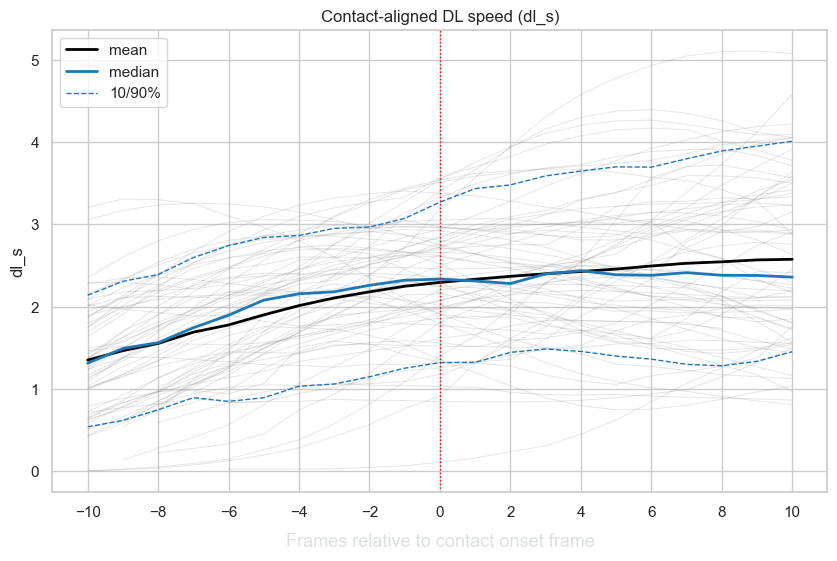

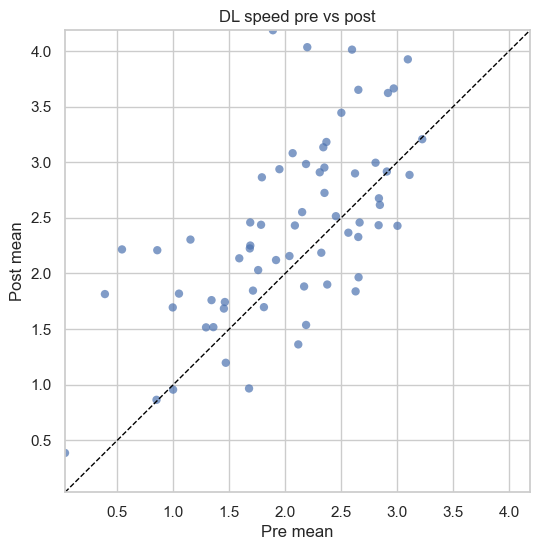

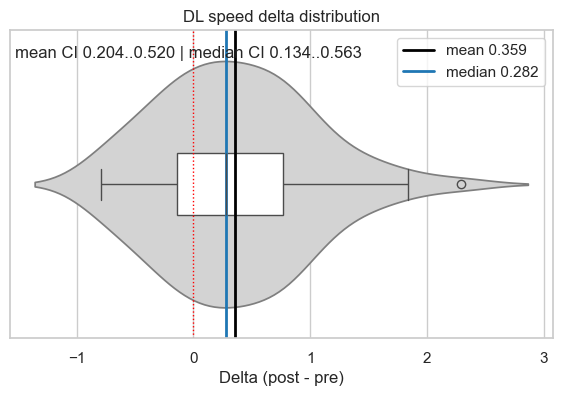

In [36]:
plot_contact_aligned_spaghetti(df_pd, "dl_s", "Contact-aligned DL speed (dl_s)")
plot_pre_post_scatter(dl_speed_pre_post, "DL speed pre vs post")
plot_delta_distribution(dl_speed_pre_post, "DL speed delta distribution")


(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': 'DL acceleration delta distribution'}, xlabel='Delta (post - pre)'>)

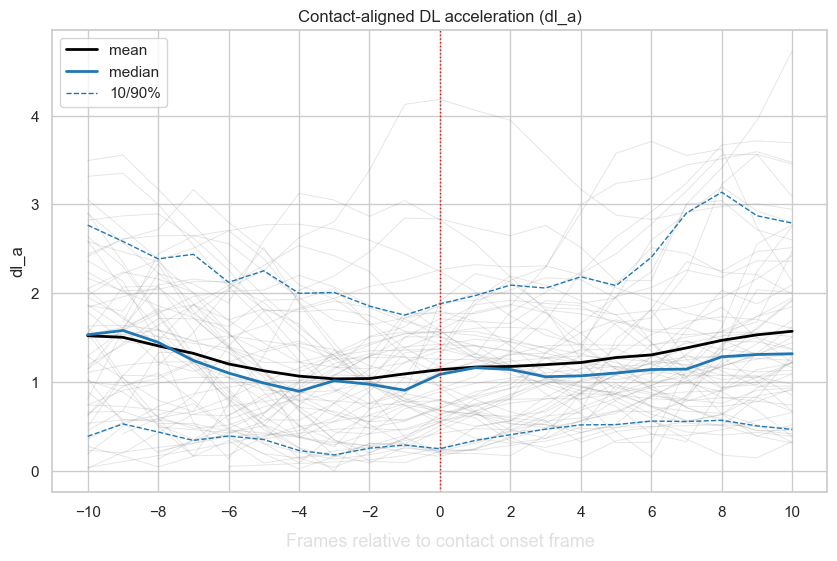

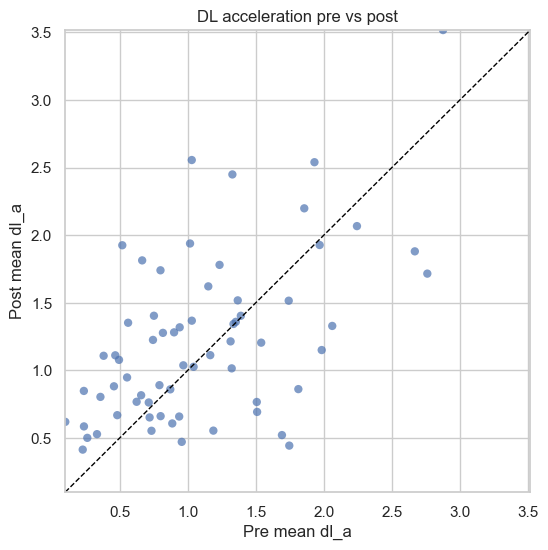

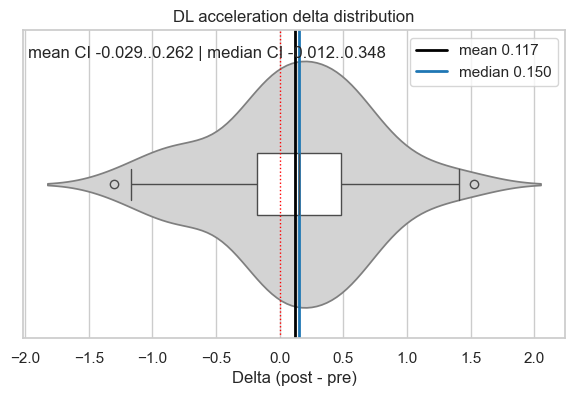

In [37]:
plot_contact_aligned_spaghetti(df_pd, "dl_a", "Contact-aligned DL acceleration (dl_a)")
plot_pre_post_scatter(dl_accel_pre_post, "DL acceleration pre vs post", x_label="Pre mean dl_a", y_label="Post mean dl_a")
plot_delta_distribution(dl_accel_pre_post, "DL acceleration delta distribution")


(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': 'Closing velocity delta distribution'}, xlabel='Delta (post - pre)'>)

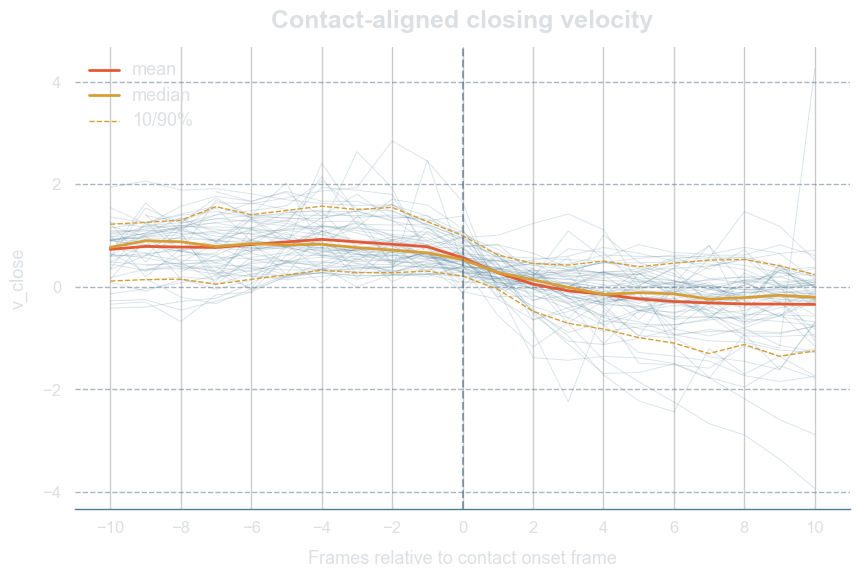

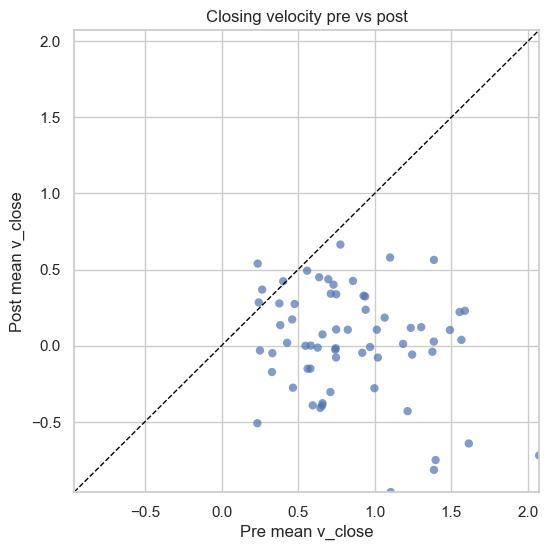

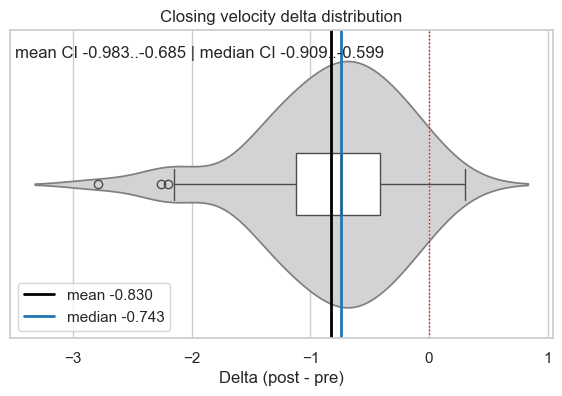

In [38]:
fig, ax = plot_contact_aligned_spaghetti_hist_style(
    df_pd,
    "v_close",
    "Contact-aligned closing velocity",
    output_path="v_close_spaghetti_histogram_style.svg",
)
fig
plot_pre_post_scatter(vclose_pre_post, "Closing velocity pre vs post", x_label="Pre mean v_close", y_label="Post mean v_close")
plot_delta_distribution(vclose_pre_post, "Closing velocity delta distribution")




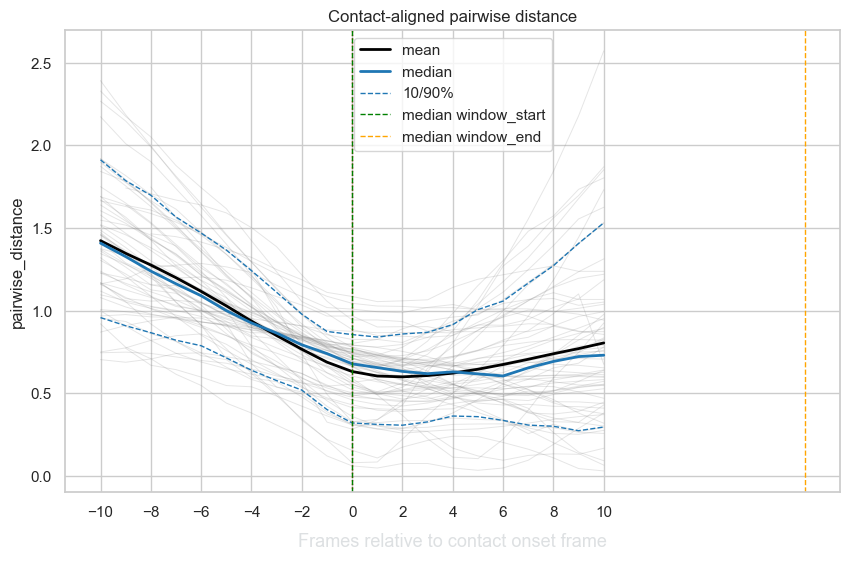

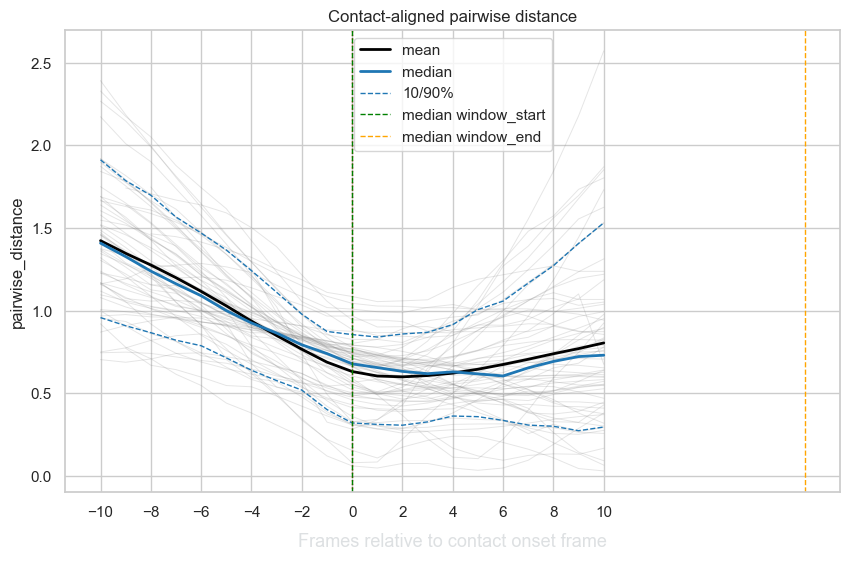

In [39]:
fig, ax = plot_contact_aligned_spaghetti(df_pd, "pairwise_distance", "Contact-aligned pairwise distance")

rel_window_start = (rep_meta["window_start"] - rep_meta["contact_onset_frame"]).dropna()
rel_window_end = (rep_meta["window_end"] - rep_meta["contact_onset_frame"]).dropna()

if not rel_window_start.empty:
    ax.axvline(rel_window_start.median(), color="green", linestyle="--", linewidth=1, label="median window_start")
if not rel_window_end.empty:
    ax.axvline(rel_window_end.median(), color="orange", linestyle="--", linewidth=1, label="median window_end")

ax.legend()
fig


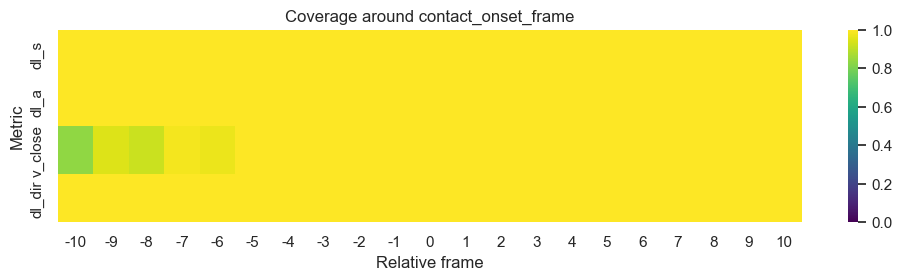

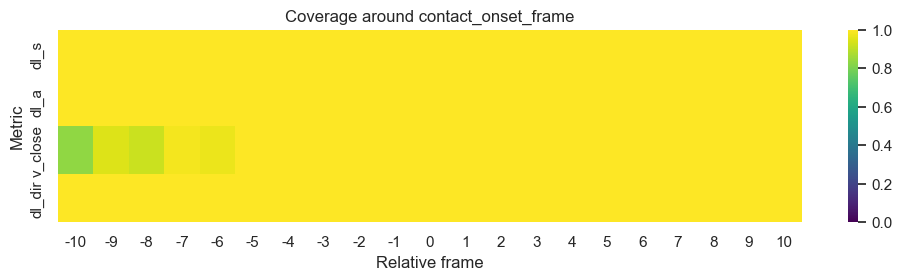

In [40]:
metrics = ["dl_s", "dl_a", "v_close", "dl_dir"]
metrics = [m for m in metrics if m in df_pd.columns]

subset = df_pd[(df_pd["rel_frame"] >= REL_FRAME_MIN) & (df_pd["rel_frame"] <= REL_FRAME_MAX)]
coverage = subset.groupby("rel_frame")[metrics].agg(lambda s: s.notna().mean()).T

fig, ax = plt.subplots(figsize=(12, 2.5))
sns.heatmap(coverage, ax=ax, cmap="viridis", vmin=0, vmax=1)
ax.set_title("Coverage around contact_onset_frame")
ax.set_xlabel("Relative frame")
ax.set_ylabel("Metric")
fig


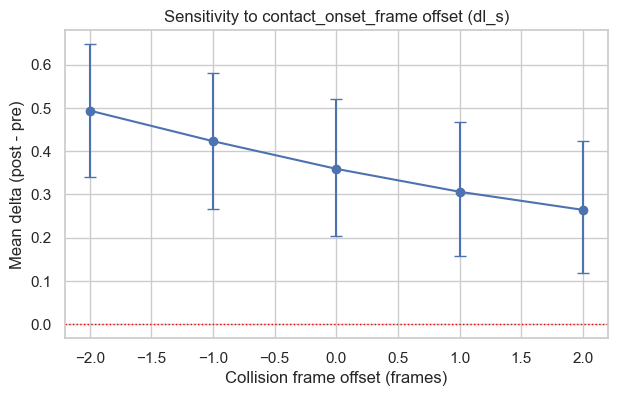

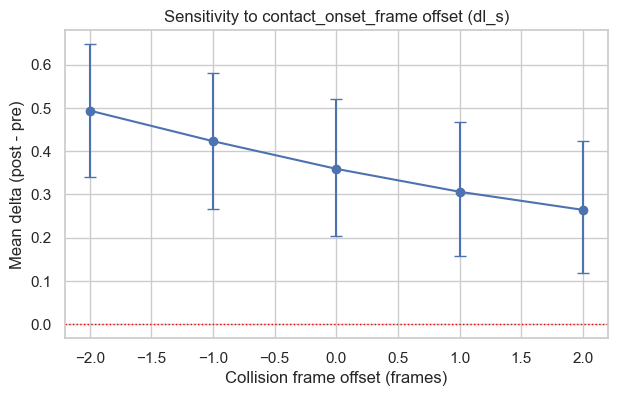

In [41]:
offsets = [-2, -1, 0, 1, 2]
rows = []
for k in offsets:
    pre_post = compute_pre_post_by_rep(df_pd, "dl_s", pre_frames=PRE_FRAMES, post_frames=POST_FRAMES, center_offset=k)
    data = pre_post["delta"].dropna().to_numpy()
    if data.size == 0:
        continue
    mean = data.mean()
    ci_low, ci_high = bootstrap_ci(data, np.mean)
    rows.append({"offset": k, "mean": mean, "ci_low": ci_low, "ci_high": ci_high, "n": len(data)})

offset_summary = pd.DataFrame(rows)

fig, ax = plt.subplots(figsize=(7, 4))
ax.errorbar(
    offset_summary["offset"],
    offset_summary["mean"],
    yerr=[offset_summary["mean"] - offset_summary["ci_low"], offset_summary["ci_high"] - offset_summary["mean"]],
    fmt="o-",
    capsize=4,
)
ax.axhline(0, color="red", linestyle=":", linewidth=1)
ax.set_xlabel("Collision frame offset (frames)")
ax.set_ylabel("Mean delta (post - pre)")
ax.set_title("Sensitivity to contact_onset_frame offset (dl_s)")
fig


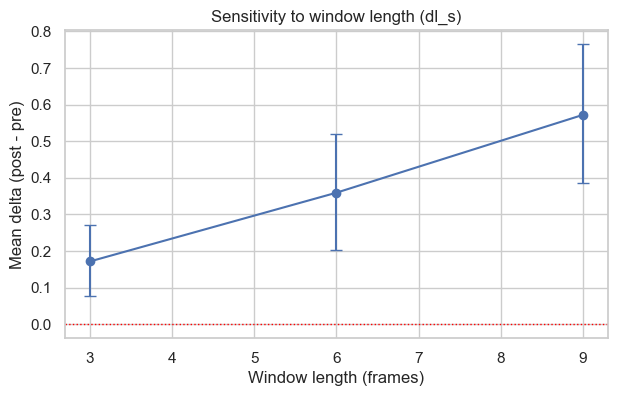

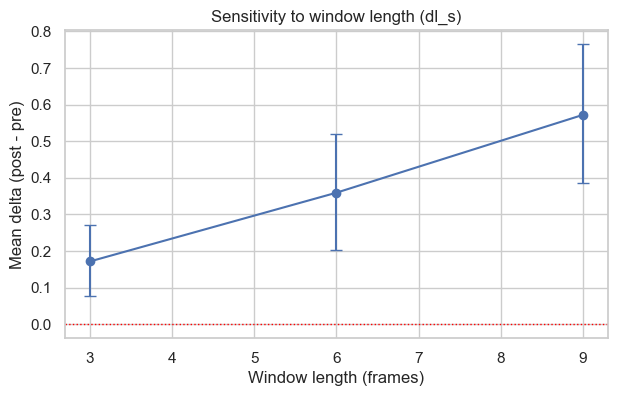

In [42]:
window_lengths = [3, 6, 9]
rows = []
for w in window_lengths:
    pre_post = compute_pre_post_by_rep(df_pd, "dl_s", pre_frames=w, post_frames=w, center_offset=0)
    data = pre_post["delta"].dropna().to_numpy()
    if data.size == 0:
        continue
    mean = data.mean()
    ci_low, ci_high = bootstrap_ci(data, np.mean)
    rows.append({"window": w, "mean": mean, "ci_low": ci_low, "ci_high": ci_high, "n": len(data)})

window_summary = pd.DataFrame(rows)

fig, ax = plt.subplots(figsize=(7, 4))
ax.errorbar(
    window_summary["window"],
    window_summary["mean"],
    yerr=[window_summary["mean"] - window_summary["ci_low"], window_summary["ci_high"] - window_summary["mean"]],
    fmt="o-",
    capsize=4,
)
ax.axhline(0, color="red", linestyle=":", linewidth=1)
ax.set_xlabel("Window length (frames)")
ax.set_ylabel("Mean delta (post - pre)")
ax.set_title("Sensitivity to window length (dl_s)")
fig


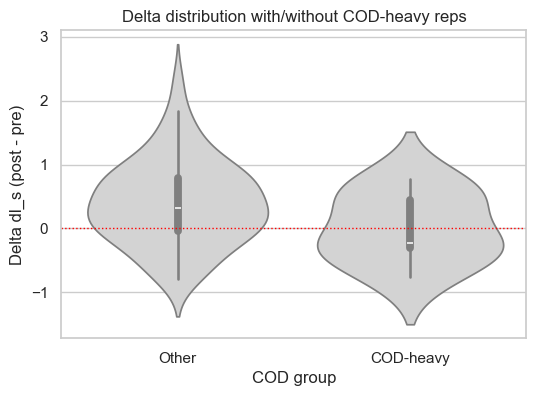

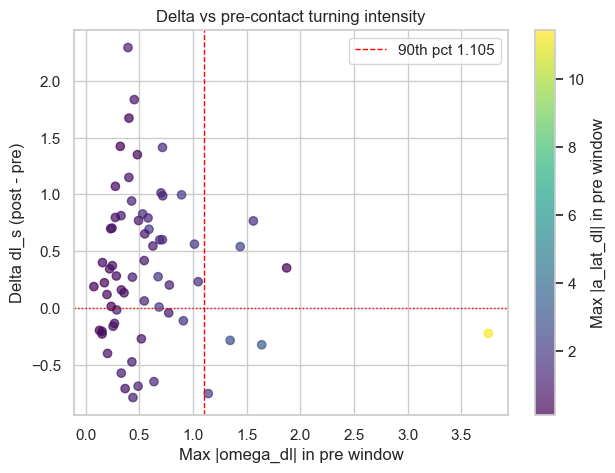

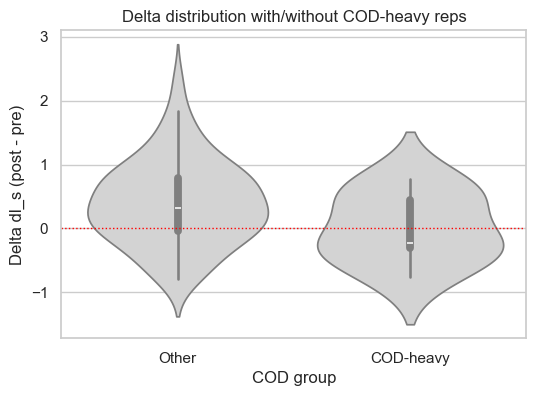

In [43]:
def compute_pre_window_stat(df, value_col, pre_frames=PRE_FRAMES, stat="max_abs"):
    rows = []
    for rep_id, g in df.groupby("rep_id"):
        center = g["contact_onset_frame"].iloc[0]
        pre_mask = (g["frame_number"] >= center - pre_frames) & (g["frame_number"] <= center - 1)
        vals = g.loc[pre_mask, value_col].dropna()
        if vals.empty:
            continue
        if stat == "max_abs":
            val = vals.abs().max()
        elif stat == "mean_abs":
            val = vals.abs().mean()
        elif stat == "max":
            val = vals.max()
        else:
            val = vals.mean()
        rows.append({"rep_id": rep_id, f"{value_col}_{stat}": val})
    return pd.DataFrame(rows)

omega_pre = compute_pre_window_stat(df_pd, "omega_dl", pre_frames=PRE_FRAMES, stat="max_abs")
a_lat_pre = compute_pre_window_stat(df_pd, "a_lat_dl", pre_frames=PRE_FRAMES, stat="max_abs")
jerk_pre = compute_pre_window_stat(df_pd, "jerk_dl", pre_frames=PRE_FRAMES, stat="max_abs")

cod_df = dl_speed_pre_post.merge(omega_pre, on="rep_id", how="left")
cod_df = cod_df.merge(a_lat_pre, on="rep_id", how="left")
cod_df = cod_df.merge(jerk_pre, on="rep_id", how="left")

omega_col = "omega_dl_max_abs"
a_lat_col = "a_lat_dl_max_abs"

threshold = np.nanpercentile(cod_df[omega_col].to_numpy(), 90)
cod_df["cod_group"] = np.where(cod_df[omega_col] >= threshold, "COD-heavy", "Other")

fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(cod_df[omega_col], cod_df["delta"], c=cod_df[a_lat_col], cmap="viridis", alpha=0.7)
ax.axvline(threshold, color="red", linestyle="--", linewidth=1, label=f"90th pct {threshold:.3f}")
ax.axhline(0, color="red", linestyle=":", linewidth=1)
ax.set_xlabel("Max |omega_dl| in pre window")
ax.set_ylabel("Delta dl_s (post - pre)")
ax.set_title("Delta vs pre-contact turning intensity")
ax.legend()
plt.colorbar(sc, ax=ax, label="Max |a_lat_dl| in pre window")
fig

fig, ax = plt.subplots(figsize=(6, 4))
sns.violinplot(data=cod_df, x="cod_group", y="delta", ax=ax, inner="box", color="lightgray")
ax.axhline(0, color="red", linestyle=":", linewidth=1)
ax.set_xlabel("COD group")
ax.set_ylabel("Delta dl_s (post - pre)")
ax.set_title("Delta distribution with/without COD-heavy reps")
fig


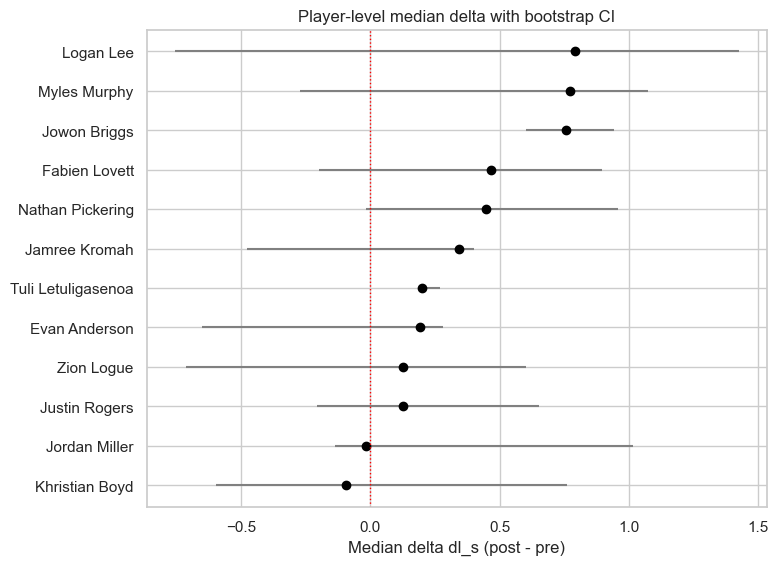

In [44]:
MIN_REPS_PER_PLAYER = 3

player_data = dl_speed_pre_post.copy()
player_data["player_id"] = player_data["dl_player_name"].fillna(player_data["dl_zebra_id"].astype(str))

player_rows = []
for player_id, g in player_data.groupby("player_id"):
    if len(g) < MIN_REPS_PER_PLAYER:
        continue
    data = g["delta"].dropna().to_numpy()
    if data.size == 0:
        continue
    med = np.median(data)
    ci_low, ci_high = bootstrap_ci(data, np.median)
    player_rows.append({"player_id": player_id, "median": med, "ci_low": ci_low, "ci_high": ci_high, "n": len(data)})

player_stats = pd.DataFrame(player_rows).sort_values("median")

if player_stats.empty:
    print("No players with >=", MIN_REPS_PER_PLAYER, "reps.")
else:
    fig, ax = plt.subplots(figsize=(8, 0.35 * len(player_stats) + 2))
    y = np.arange(len(player_stats))
    ax.hlines(y, player_stats["ci_low"], player_stats["ci_high"], color="gray")
    ax.plot(player_stats["median"], y, "o", color="black")
    ax.axvline(0, color="red", linestyle=":", linewidth=1)
    ax.set_yticks(y)
    ax.set_yticklabels(player_stats["player_id"])
    ax.set_xlabel("Median delta dl_s (post - pre)")
    ax.set_title("Player-level median delta with bootstrap CI")
    fig


## OL diagnostics

In [45]:
ol_speed_pre_post = compute_pre_post_by_rep(df_pd, "ol_s", pre_frames=PRE_FRAMES, post_frames=POST_FRAMES)
ol_speed_pre_post = ol_speed_pre_post.merge(rep_meta, on="rep_id", how="left")

ol_accel_pre_post = compute_pre_post_by_rep(df_pd, "ol_a", pre_frames=PRE_FRAMES, post_frames=POST_FRAMES)
ol_accel_pre_post = ol_accel_pre_post.merge(rep_meta, on="rep_id", how="left")

print("ol_s reps", len(ol_speed_pre_post))
print("ol_a reps", len(ol_accel_pre_post))


ol_s reps 65
ol_a reps 65


(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': 'OL speed delta distribution'}, xlabel='Delta (post - pre)'>)

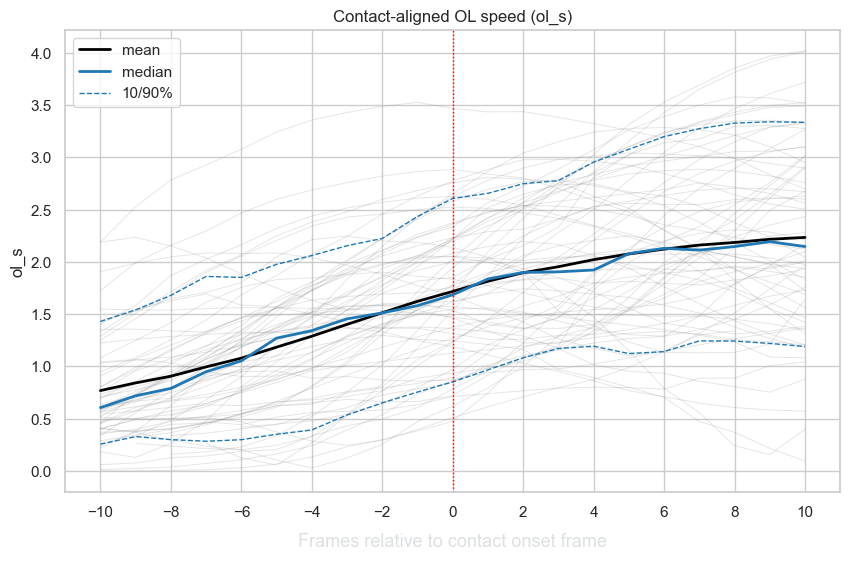

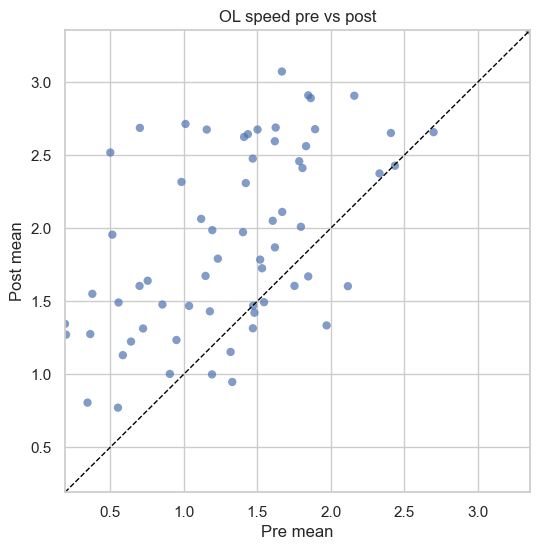

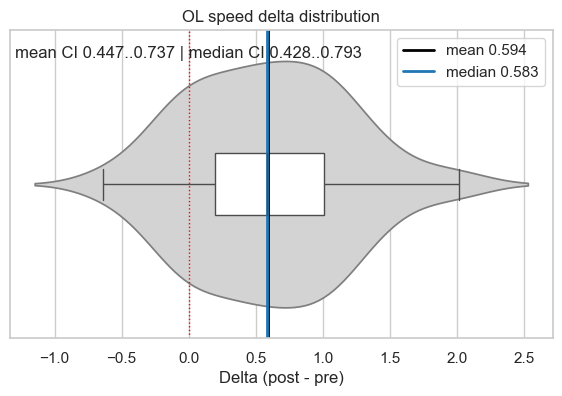

In [46]:
plot_contact_aligned_spaghetti(df_pd, "ol_s", "Contact-aligned OL speed (ol_s)")
plot_pre_post_scatter(ol_speed_pre_post, "OL speed pre vs post")
plot_delta_distribution(ol_speed_pre_post, "OL speed delta distribution")


(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': 'OL acceleration delta distribution'}, xlabel='Delta (post - pre)'>)

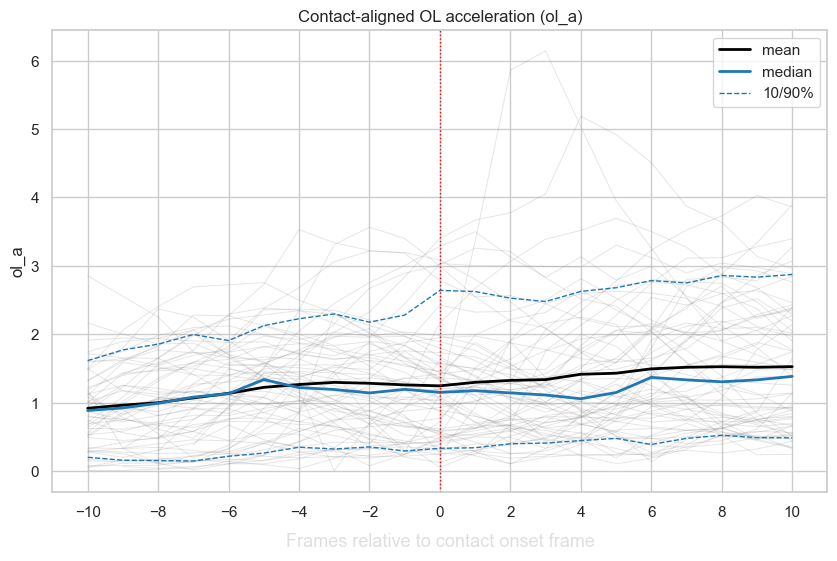

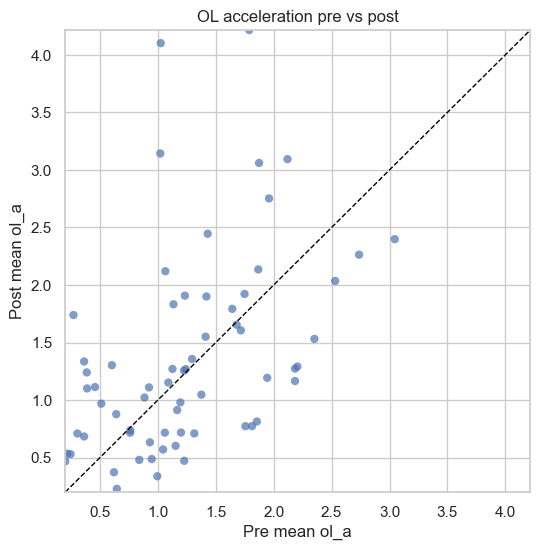

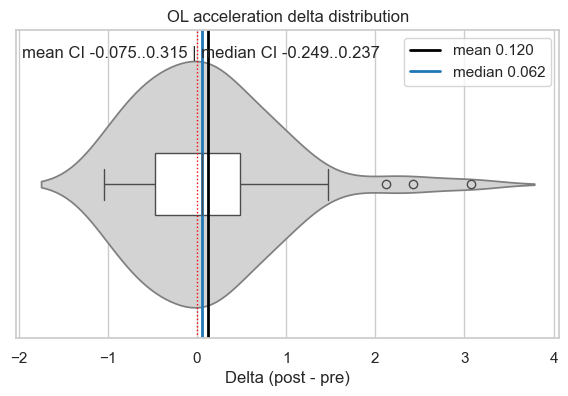

In [47]:
plot_contact_aligned_spaghetti(df_pd, "ol_a", "Contact-aligned OL acceleration (ol_a)")
plot_pre_post_scatter(ol_accel_pre_post, "OL acceleration pre vs post", x_label="Pre mean ol_a", y_label="Post mean ol_a")
plot_delta_distribution(ol_accel_pre_post, "OL acceleration delta distribution")


(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': 'Closing velocity delta distribution'}, xlabel='Delta (post - pre)'>)

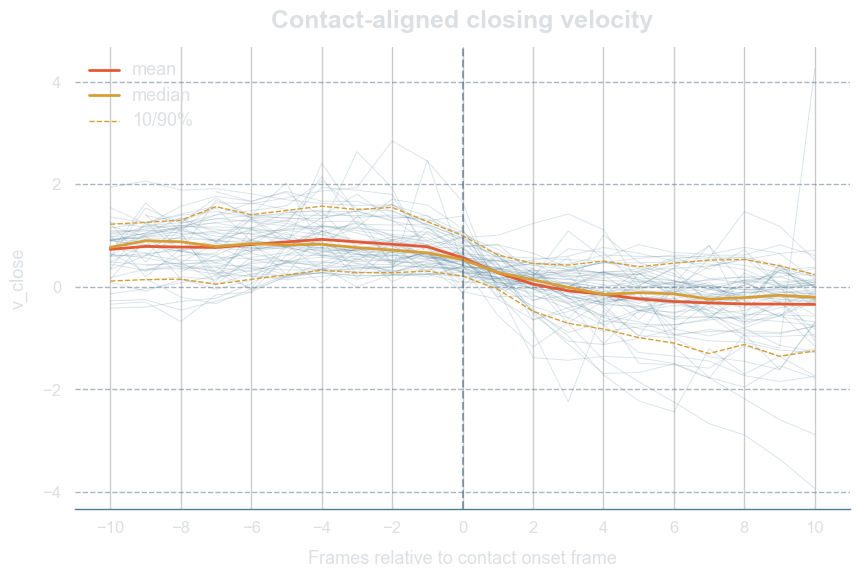

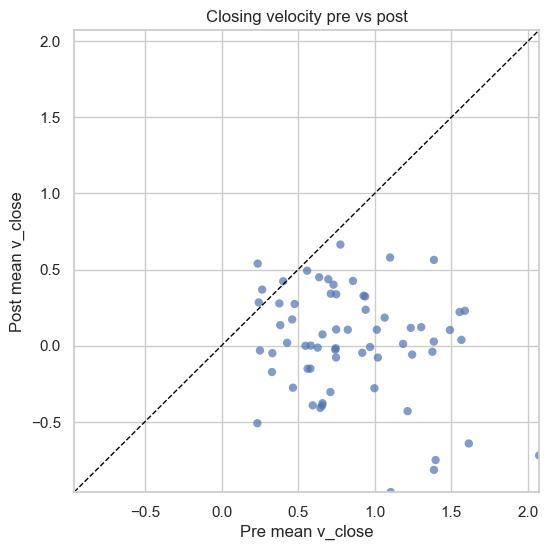

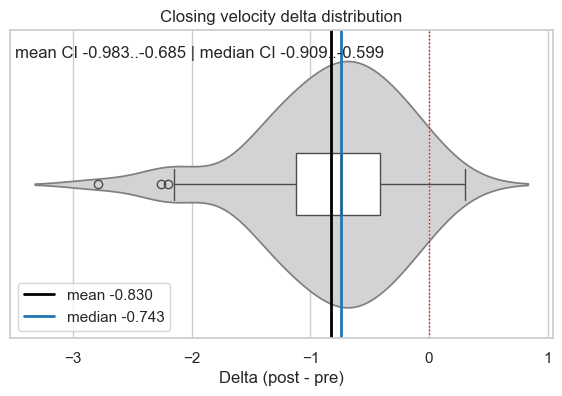

In [48]:
fig, ax = plot_contact_aligned_spaghetti_hist_style(
    df_pd,
    "v_close",
    "Contact-aligned closing velocity",
    output_path="v_close_spaghetti_histogram_style.svg",
)
fig
plot_pre_post_scatter(vclose_pre_post, "Closing velocity pre vs post", x_label="Pre mean v_close", y_label="Post mean v_close")
plot_delta_distribution(vclose_pre_post, "Closing velocity delta distribution")




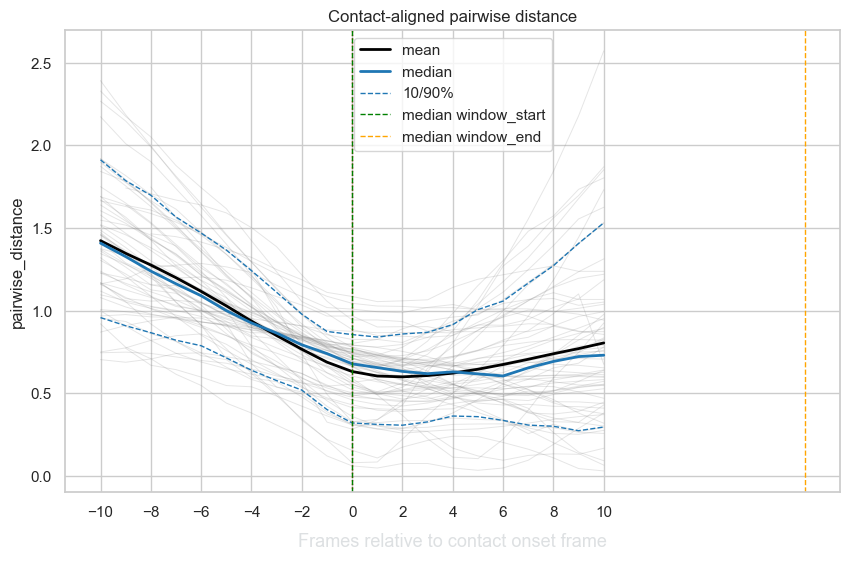

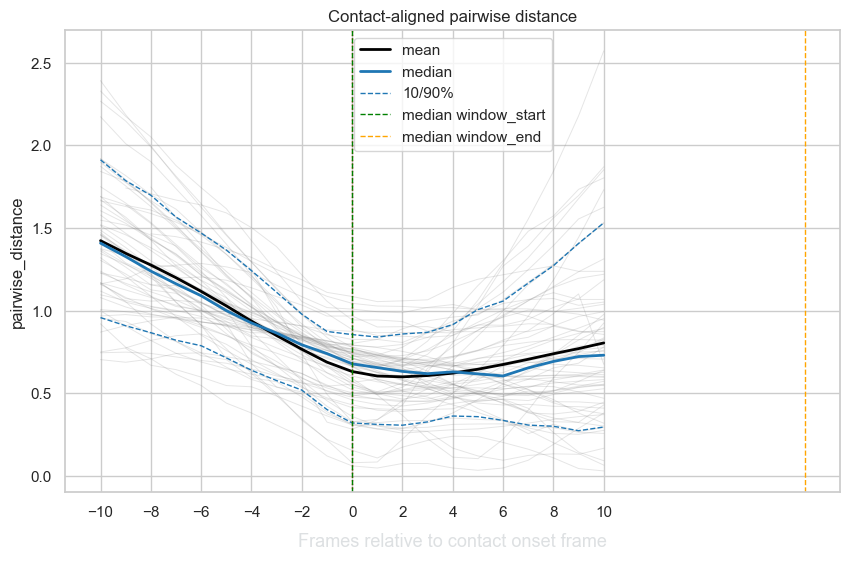

In [49]:
fig, ax = plot_contact_aligned_spaghetti(df_pd, "pairwise_distance", "Contact-aligned pairwise distance")

rel_window_start = (rep_meta["window_start"] - rep_meta["contact_onset_frame"]).dropna()
rel_window_end = (rep_meta["window_end"] - rep_meta["contact_onset_frame"]).dropna()

if not rel_window_start.empty:
    ax.axvline(rel_window_start.median(), color="green", linestyle="--", linewidth=1, label="median window_start")
if not rel_window_end.empty:
    ax.axvline(rel_window_end.median(), color="orange", linestyle="--", linewidth=1, label="median window_end")

ax.legend()
fig


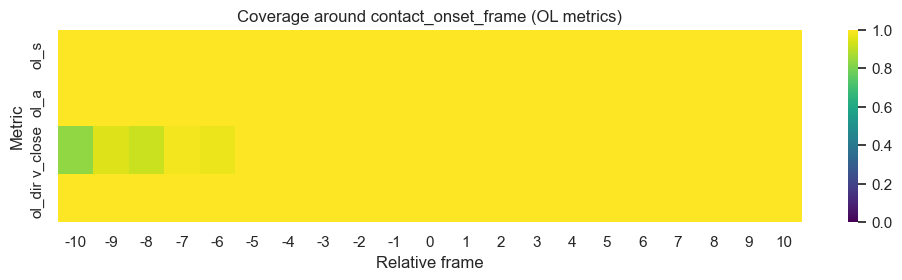

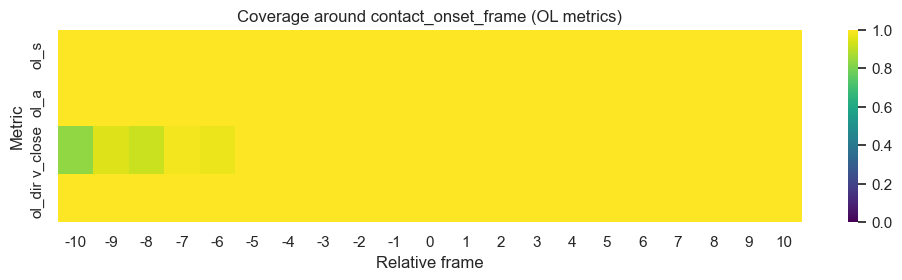

In [50]:
metrics = ["ol_s", "ol_a", "v_close", "ol_dir"]
metrics = [m for m in metrics if m in df_pd.columns]

subset = df_pd[(df_pd["rel_frame"] >= REL_FRAME_MIN) & (df_pd["rel_frame"] <= REL_FRAME_MAX)]
coverage = subset.groupby("rel_frame")[metrics].agg(lambda s: s.notna().mean()).T

fig, ax = plt.subplots(figsize=(12, 2.5))
sns.heatmap(coverage, ax=ax, cmap="viridis", vmin=0, vmax=1)
ax.set_title("Coverage around contact_onset_frame (OL metrics)")
ax.set_xlabel("Relative frame")
ax.set_ylabel("Metric")
fig


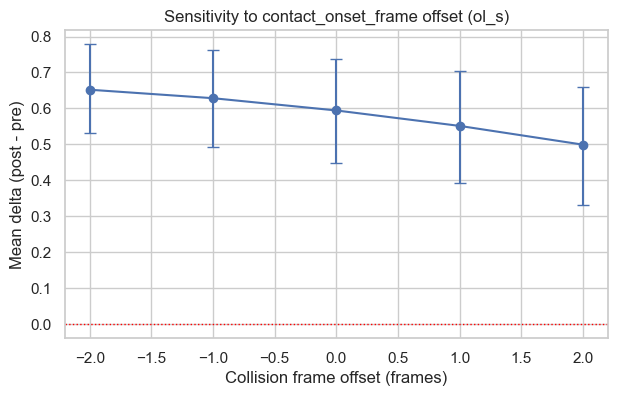

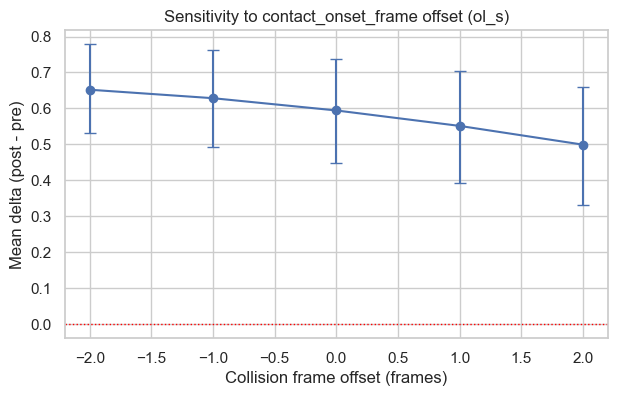

In [51]:
offsets = [-2, -1, 0, 1, 2]
rows = []
for k in offsets:
    pre_post = compute_pre_post_by_rep(df_pd, "ol_s", pre_frames=PRE_FRAMES, post_frames=POST_FRAMES, center_offset=k)
    data = pre_post["delta"].dropna().to_numpy()
    if data.size == 0:
        continue
    mean = data.mean()
    ci_low, ci_high = bootstrap_ci(data, np.mean)
    rows.append({"offset": k, "mean": mean, "ci_low": ci_low, "ci_high": ci_high, "n": len(data)})

offset_summary = pd.DataFrame(rows)

fig, ax = plt.subplots(figsize=(7, 4))
ax.errorbar(
    offset_summary["offset"],
    offset_summary["mean"],
    yerr=[offset_summary["mean"] - offset_summary["ci_low"], offset_summary["ci_high"] - offset_summary["mean"]],
    fmt="o-",
    capsize=4,
)
ax.axhline(0, color="red", linestyle=":", linewidth=1)
ax.set_xlabel("Collision frame offset (frames)")
ax.set_ylabel("Mean delta (post - pre)")
ax.set_title("Sensitivity to contact_onset_frame offset (ol_s)")
fig


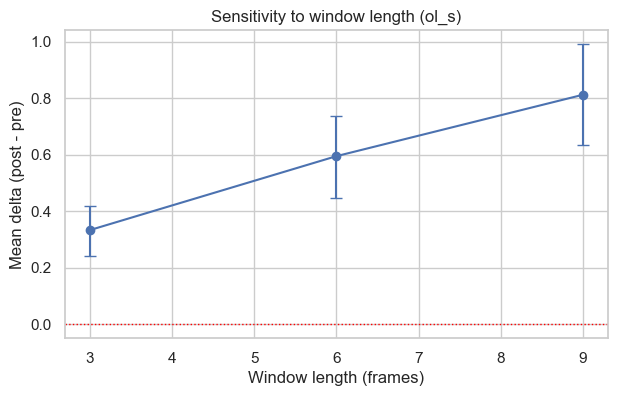

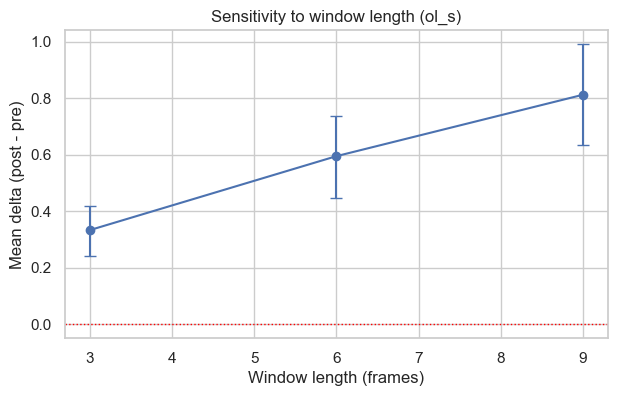

In [52]:
window_lengths = [3, 6, 9]
rows = []
for w in window_lengths:
    pre_post = compute_pre_post_by_rep(df_pd, "ol_s", pre_frames=w, post_frames=w, center_offset=0)
    data = pre_post["delta"].dropna().to_numpy()
    if data.size == 0:
        continue
    mean = data.mean()
    ci_low, ci_high = bootstrap_ci(data, np.mean)
    rows.append({"window": w, "mean": mean, "ci_low": ci_low, "ci_high": ci_high, "n": len(data)})

window_summary = pd.DataFrame(rows)

fig, ax = plt.subplots(figsize=(7, 4))
ax.errorbar(
    window_summary["window"],
    window_summary["mean"],
    yerr=[window_summary["mean"] - window_summary["ci_low"], window_summary["ci_high"] - window_summary["mean"]],
    fmt="o-",
    capsize=4,
)
ax.axhline(0, color="red", linestyle=":", linewidth=1)
ax.set_xlabel("Window length (frames)")
ax.set_ylabel("Mean delta (post - pre)")
ax.set_title("Sensitivity to window length (ol_s)")
fig


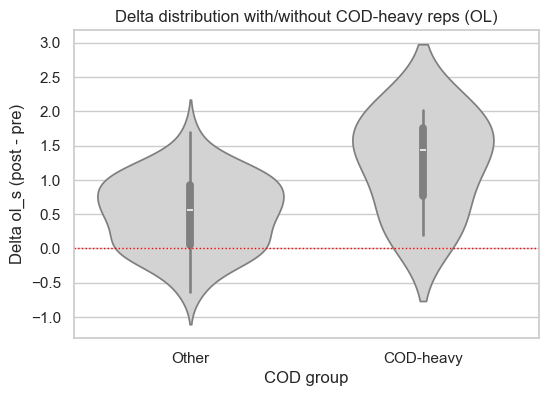

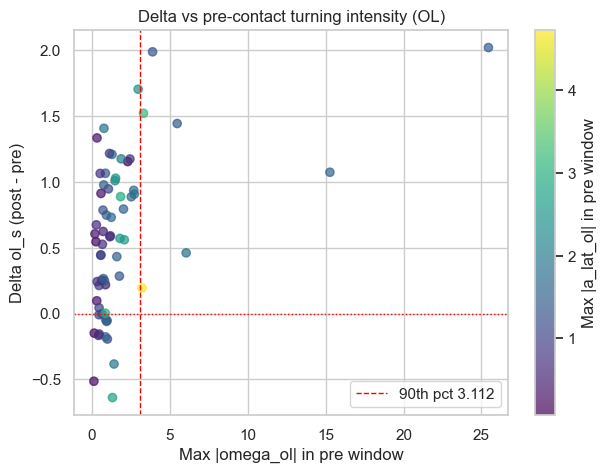

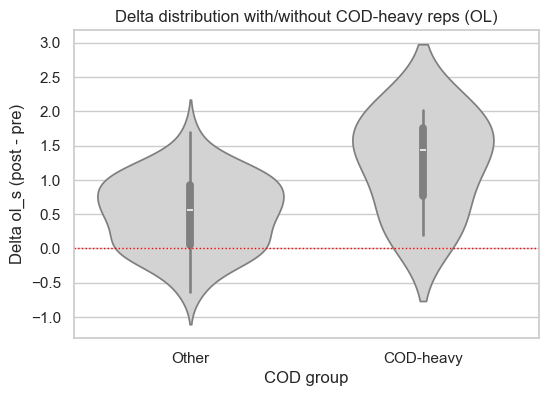

In [53]:
omega_pre = compute_pre_window_stat(df_pd, "omega_ol", pre_frames=PRE_FRAMES, stat="max_abs")
a_lat_pre = compute_pre_window_stat(df_pd, "a_lat_ol", pre_frames=PRE_FRAMES, stat="max_abs")
jerk_pre = compute_pre_window_stat(df_pd, "jerk_ol", pre_frames=PRE_FRAMES, stat="max_abs")

cod_df = ol_speed_pre_post.merge(omega_pre, on="rep_id", how="left")
cod_df = cod_df.merge(a_lat_pre, on="rep_id", how="left")
cod_df = cod_df.merge(jerk_pre, on="rep_id", how="left")

omega_col = "omega_ol_max_abs"
a_lat_col = "a_lat_ol_max_abs"

threshold = np.nanpercentile(cod_df[omega_col].to_numpy(), 90)
cod_df["cod_group"] = np.where(cod_df[omega_col] >= threshold, "COD-heavy", "Other")

fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(cod_df[omega_col], cod_df["delta"], c=cod_df[a_lat_col], cmap="viridis", alpha=0.7)
ax.axvline(threshold, color="red", linestyle="--", linewidth=1, label=f"90th pct {threshold:.3f}")
ax.axhline(0, color="red", linestyle=":", linewidth=1)
ax.set_xlabel("Max |omega_ol| in pre window")
ax.set_ylabel("Delta ol_s (post - pre)")
ax.set_title("Delta vs pre-contact turning intensity (OL)")
ax.legend()
plt.colorbar(sc, ax=ax, label="Max |a_lat_ol| in pre window")
fig

fig, ax = plt.subplots(figsize=(6, 4))
sns.violinplot(data=cod_df, x="cod_group", y="delta", ax=ax, inner="box", color="lightgray")
ax.axhline(0, color="red", linestyle=":", linewidth=1)
ax.set_xlabel("COD group")
ax.set_ylabel("Delta ol_s (post - pre)")
ax.set_title("Delta distribution with/without COD-heavy reps (OL)")
fig


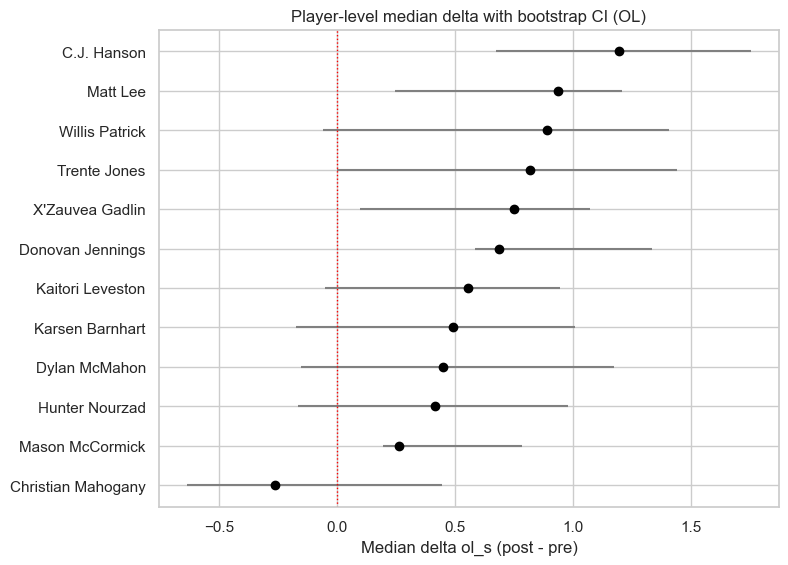

In [54]:
player_data = ol_speed_pre_post.copy()
player_data["player_id"] = player_data["ol_player_name"].fillna(player_data["ol_zebra_id"].astype(str))

player_rows = []
for player_id, g in player_data.groupby("player_id"):
    if len(g) < MIN_REPS_PER_PLAYER:
        continue
    data = g["delta"].dropna().to_numpy()
    if data.size == 0:
        continue
    med = np.median(data)
    ci_low, ci_high = bootstrap_ci(data, np.median)
    player_rows.append({"player_id": player_id, "median": med, "ci_low": ci_low, "ci_high": ci_high, "n": len(data)})

player_stats = pd.DataFrame(player_rows).sort_values("median")

if player_stats.empty:
    print("No players with >=", MIN_REPS_PER_PLAYER, "reps.")
else:
    fig, ax = plt.subplots(figsize=(8, 0.35 * len(player_stats) + 2))
    y = np.arange(len(player_stats))
    ax.hlines(y, player_stats["ci_low"], player_stats["ci_high"], color="gray")
    ax.plot(player_stats["median"], y, "o", color="black")
    ax.axvline(0, color="red", linestyle=":", linewidth=1)
    ax.set_yticks(y)
    ax.set_yticklabels(player_stats["player_id"])
    ax.set_xlabel("Median delta ol_s (post - pre)")
    ax.set_title("Player-level median delta with bootstrap CI (OL)")
    fig
